In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import re

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

np.random.seed(2023)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load, rename and split the data
PATH = "drive/MyDrive/ML_Cog/ML_housing_project/"
train = pd.read_csv(PATH + "/housing_train.csv", index_col=0)
test = pd.read_csv(PATH + "housing_test.csv", index_col=0)

column_indices = [11, 12, 13, 14, 15]
old_names = train.columns[column_indices]
new_names = ["ocean_proximity_" + x for x in list(old_names)]
train.rename(columns=dict(zip(old_names, new_names)), inplace=True)
train.rename(columns={'ocean_proximity_NEAR BAY':'ocean_proximity_NEAR_BAY', 'ocean_proximity_NEAR OCEAN':'ocean_proximity_NEAR_OCEAN', "ocean_proximity_<1H OCEAN": "ocean_proximity_<1H_OCEAN"}, inplace=True)
test.rename(columns=dict(zip(old_names, new_names)), inplace=True)
test.rename(columns={'ocean_proximity_NEAR BAY':'ocean_proximity_NEAR_BAY', 'ocean_proximity_NEAR OCEAN':'ocean_proximity_NEAR_OCEAN', "ocean_proximity_<1H OCEAN": "ocean_proximity_<1H_OCEAN"}, inplace=True)


X_train, y_train = train.drop(columns=['median_house_value']), train['median_house_value']
X_test, y_test = test.drop(columns=['median_house_value']), test['median_house_value']

In [5]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity_<1H_OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR_BAY,ocean_proximity_NEAR_OCEAN
7824,0.566948,-0.825018,-0.081059,1.120375,1.788007,1.091089,1.871761,-0.215153,-0.521122,-0.730505,0.603484,1.0,0.0,0.0,0.0,0.0
10035,0.748708,-0.829673,-0.871539,-0.512888,-0.337793,-0.506102,-0.423430,-0.516456,-0.402252,-0.391948,0.757052,1.0,0.0,0.0,0.0,0.0
16196,-1.275902,0.823036,-0.168890,0.055789,-0.279328,-0.175471,-0.213145,1.871930,0.501810,-0.005688,-0.960513,1.0,0.0,0.0,0.0,0.0
10363,0.743660,-0.843640,-0.695877,-0.010691,-0.164736,-0.267600,-0.146469,1.427811,0.200568,-0.392412,-0.540044,1.0,0.0,0.0,0.0,0.0
11659,-0.902283,1.423598,-0.168890,0.051746,0.122914,-0.192691,0.033044,-0.504926,-0.021345,-0.560719,0.005423,0.0,1.0,0.0,0.0,0.0


In [6]:
# helper functions from class

class ColumnDropper(BaseEstimator, TransformerMixin):

    def __init__(self, col_names: list):
        self.col_names = col_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.col_names)



def plot_residuals(y_true, y_pred, color = "blue"):

    residuals = y_true - y_pred

    plt.scatter(x=y_pred,
                y=residuals,
                color=color, alpha=0.6)
    plt.axhline(y=0, ls="--", color='grey')

    plt.title("Residuals vs predictions")
    plt.xlabel("y_preds")
    plt.ylabel("residuals")

    plt.show()


def plot_target_distributions(y_true, y_pred):

    plt.hist(y_true, bins=min(len(y_true), 20), color='blue', alpha=0.3, label='true')
    plt.hist(y_pred, bins=min(len(y_pred), 20), color='green', alpha=0.3, label='preds')
    plt.legend()
    plt.show()

In [7]:
def regression_report(y_true, y_pred, color="blue"):

    print("R2 score", r2_score(y_true, y_pred))
    print("MAE", mean_absolute_error(y_true, y_pred))
    print("MSE", mean_squared_error(y_true, y_pred))

    plot_residuals(y_true, y_pred, color = color)
    plot_target_distributions(y_true, y_pred)

In [8]:
def create_regression_model(model_instance, X_train, y_train, X_test, y_test):

    """
    Wrapper for fitting and evaluating a regression model
    """

    model_instance.fit(X_train, y_train)
    y_pred_train = model_instance.predict(X_train)
    y_pred_test = model_instance.predict(X_test)

    print("TRAIN")
    regression_report(y_train, y_pred_train, color="red")

    print("--"*10)

    print("TEST")
    regression_report(y_test, y_pred_test, color="blue")

    return model_instance

In [9]:
pipeline = Pipeline([
                    ('dropper', ColumnDropper(["ocean_proximity_NEAR_OCEAN"])),
                    ('poly', PolynomialFeatures(degree=2, include_bias=True)),
                    ('model', Ridge(alpha=8))
                    ])

TRAIN
R2 score 0.7080848545719937
MAE 36903.8727706032
MSE 2648027822.5934253


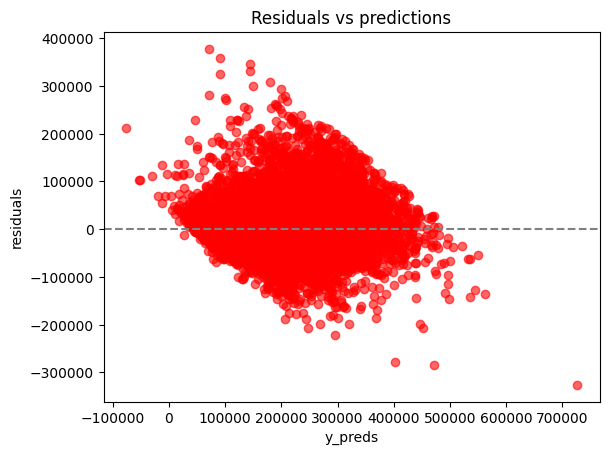

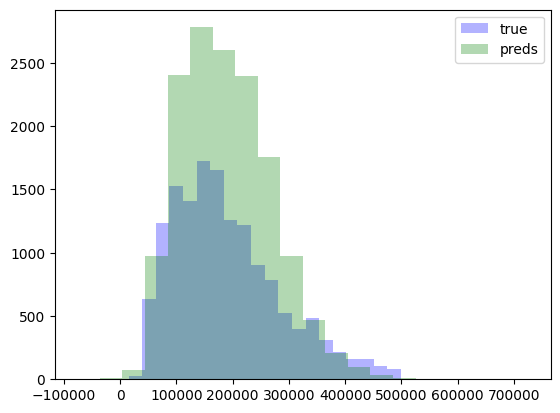

--------------------
TEST
R2 score 0.6950709501183432
MAE 37451.77886223928
MSE 2786668665.607529


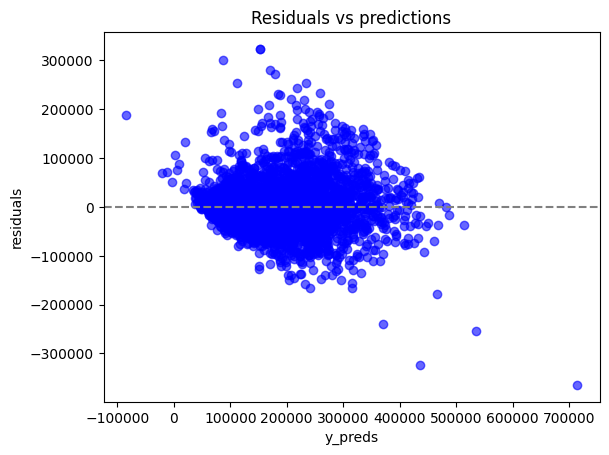

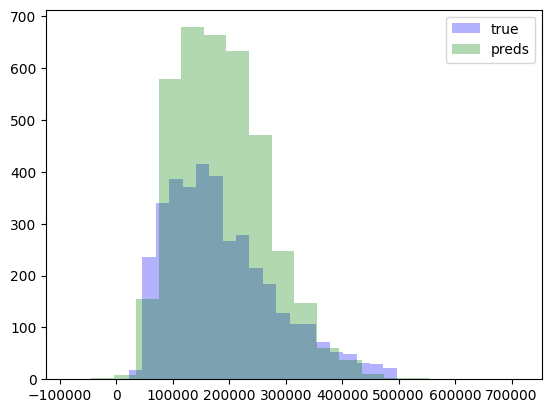

In [10]:
pipeline = create_regression_model(pipeline, X_train, y_train, X_test, y_test)

In [11]:
pipeline.score(X_test, y_test)

0.6950709501183432

In [12]:
# finding best hyperparameters

params = {'model__alpha': np.arange(0, 50, 1)}

search = GridSearchCV(pipeline, params,
                      cv=10,
                      scoring='r2')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))
print('Best alpha:', search.best_params_)

Best score: 0.6336711528285897
Best alpha: {'model__alpha': 8}


In [13]:
# conclusions
dropper = pipeline.steps[0][1]
poly = pipeline.steps[1][1]
lr = pipeline.steps[2][1]

coefs = pd.DataFrame({'feature': poly.get_feature_names_out(), 'value': lr.coef_})
coefs['abs_value'] = abs(coefs['value'])
coefs.sort_values(by='abs_value', ascending=False, inplace=True)
coefs = coefs[:-1] # drop row with '1'

coef_names = [c for c in X_train.columns if c not in dropper.col_names]
name_dict = {k:v for k, v in zip(list(poly.get_feature_names_out()[1:16]), coef_names)}

In [14]:
def decode_name(name):
  if " " not in name:
    if "^2" not in name:
      return name_dict[name]
    else:
      return name_dict[name[:-2]] + " ^2"
  else:
    splt = name.split()
    n1, n2 = splt[0], splt[1]
    return name_dict[n1] + " x " + name_dict[n2]

In [15]:
coefs['feature'] = coefs['feature'].apply(decode_name)
coefs

,feature,value,abs_value
44,latitude x ocean_proximity_NEAR_BAY,-95185.812446,95185.812446
30,longitude x ocean_proximity_NEAR_BAY,-84436.374803,84436.374803
1,longitude,-78483.411121,78483.411121
2,latitude,-74342.838247,74342.838247
8,median_income,54022.810392,54022.810392
...,...,...,...
128,ocean_proximity_<1H_OCEAN x ocean_proximity_IS...,0.000000,0.000000
129,ocean_proximity_<1H_OCEAN x ocean_proximity_NE...,0.000000,0.000000
131,ocean_proximity_INLAND x ocean_proximity_ISLAND,0.000000,0.000000
132,ocean_proximity_INLAND x ocean_proximity_NEAR_BAY,0.000000,0.000000


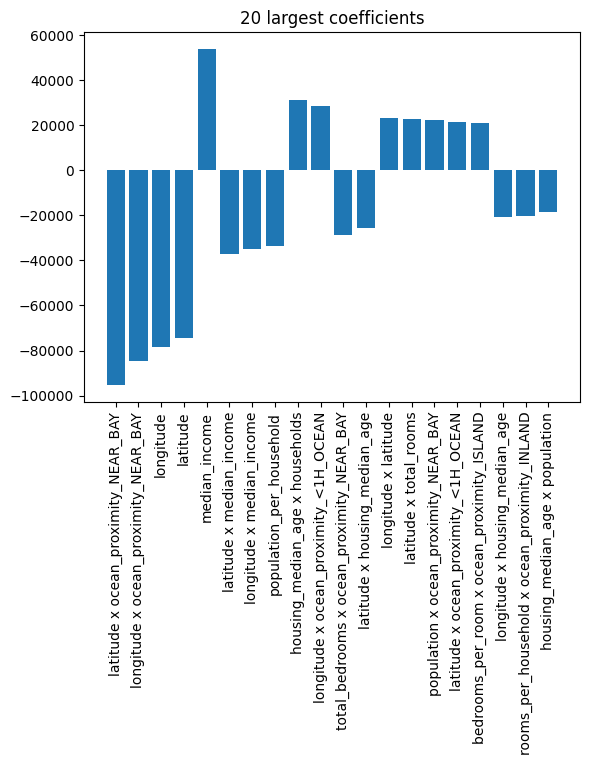

In [16]:
plt.bar(coefs['feature'][:20], coefs['value'][:20])
plt.title("20 largest coefficients")
plt.xticks(rotation=90)
plt.show()

Looking at the residual plots, we can see that the points are somewhat regularly spread along the y-axis. A slight trend downwards is visible especially on the training set, but we can generally say that linear regression assumptions are not violated here.
On the distribution plots, the shape for predicted values is very close to the true distribution.

In the pipeline, polynomial features were added and the model was changed to Ridge Regression, which improved the overall performance. The latter was to help prevent overfitting, which could arise from using the former.
From the coefficients: *longitude*, *latitude* and *median_income* seem like the best single predictors of *median_house_value*. Looking at the map of California, it makes sense that the lower the latitude and longitude - the closer it is to the ocean and so the more expensive the house would be. I think something similar is reflected by the next two polynomial features, combining those predictors with ocean proximity. Regarding *median_income*, it seems natural the house price will be higher when the neighbourhood is on average richer.

Features combining *latitude* and *longitude* with *median_income* seem weird and difficult to interpret and their large coefficients are probably only due to large coefficients assigned to those features alone. Also, *population_per_household* has the biggest impact on predictions from the features that we manually constructed and added.

All an all, the model could have a bigger $R^2$ score, but it does not overfit and its most important features are what we could expect.